In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import gensim.downloader as api

In [2]:
columns = []
with open("./data/KDDCUP/kddcup.names") as f:
    next(f, None)
    for line in f:
        parts = line.strip().split(":")
        if parts:
            columns.append(parts[0].strip())
columns.append("target")
print("Columns: {}".format( len(columns)))
print(columns)

Columns: 42
['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'target']


In [3]:
attack_types = {}
with open("./data/KDDCUP/training_attack_types") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 2:
            attack_types[parts[0]] = parts[1]
attack_types["normal"] = "normal"
print("Attack Types")
pprint(attack_types)

Attack Types
{'back': 'dos',
 'buffer_overflow': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'imap': 'r2l',
 'ipsweep': 'probe',
 'land': 'dos',
 'loadmodule': 'u2r',
 'multihop': 'r2l',
 'neptune': 'dos',
 'nmap': 'probe',
 'normal': 'normal',
 'perl': 'u2r',
 'phf': 'r2l',
 'pod': 'dos',
 'portsweep': 'probe',
 'rootkit': 'u2r',
 'satan': 'probe',
 'smurf': 'dos',
 'spy': 'r2l',
 'teardrop': 'dos',
 'warezclient': 'r2l',
 'warezmaster': 'r2l'}


In [4]:
path_kdd = "./data/KDDCUP/kddcup.data_10_percent.gz"
df_kdd = pd.read_csv(path_kdd, names=columns)
print("Shape: {}".format(df_kdd.shape))
df_kdd.head()

Shape: (494021, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [5]:
def lookup_attack(attack):
    return attack_types[attack[:-1]] # strips the "." at "
df_kdd['Attack Type'] = df_kdd.target.apply(lookup_attack)

In [6]:
df_kdd["target"].value_counts()

smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: target, dtype: int64

In [7]:
numeric_features = df_kdd.select_dtypes(include=[np.number])
numeric_features.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
non_numeric_features = df_kdd.select_dtypes(exclude=[np.number])
non_numeric_features.columns

Index(['protocol_type', 'service', 'flag', 'target', 'Attack Type'], dtype='object')

In [9]:
non_numeric_features.describe()

,protocol_type,service,flag,target,Attack Type
count,494021,494021,494021,494021,494021
unique,3,66,11,23,5
top,icmp,ecr_i,SF,smurf.,dos
freq,283602,281400,378440,280790,391458


In [10]:
def plot_df_feature(dataframe, feature, type):
    dataframe[feature].value_counts().plot(kind=type)

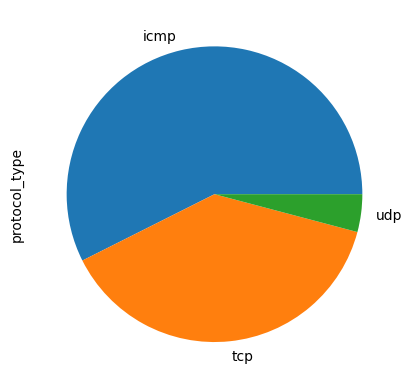

In [11]:
plot_df_feature(df_kdd, "protocol_type", "pie")

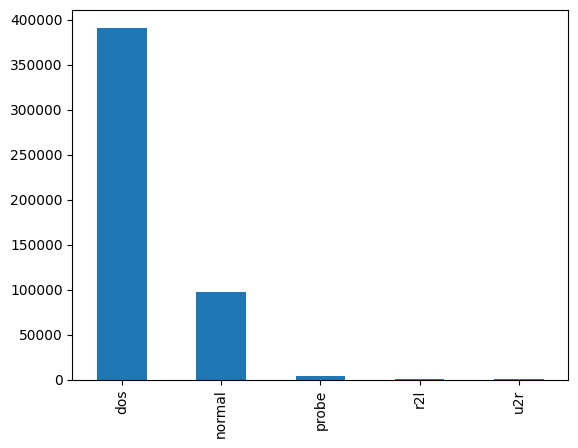

In [12]:
plot_df_feature(df_kdd, "Attack Type", "bar")

In [13]:
# removing non-unique and NaN columns
df_kdd = df_kdd.dropna(axis='columns').loc[:, df_kdd.nunique(dropna=False) > 1] 
df_kdd.shape

(494021, 41)

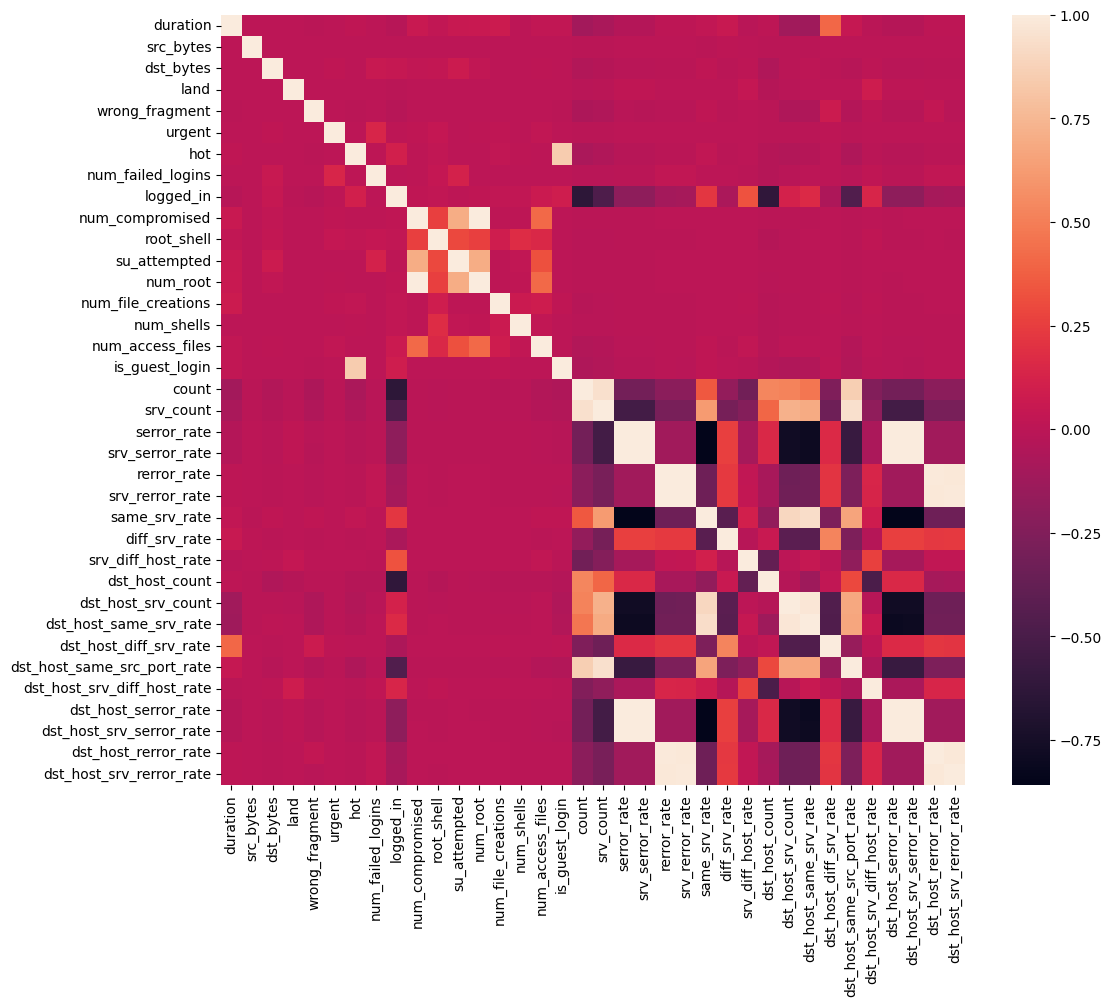

In [14]:
corr = df_kdd.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr)
plt.show() 

In [15]:
embeddingModel = api.load('glove-twitter-25')
def get_embedding_mean(word):
    try:
        return np.mean(embeddingModel[word])
    except:
        return 0.0

In [16]:
non_number_cols = ['protocol_type', 'service', 'flag', 'target']

for col in non_number_cols:
    df_kdd[col] = df_kdd[col].apply(get_embedding_mean)

df_kdd.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,Attack Type
0,0,0.104219,-0.177924,0.0,181,5450,0,0,0,0,...,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0.0,normal
1,0,0.104219,-0.177924,0.0,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,normal
2,0,0.104219,-0.177924,0.0,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,normal
3,0,0.104219,-0.177924,0.0,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,normal
4,0,0.104219,-0.177924,0.0,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,normal


In [17]:
df_kdd = df_kdd.drop(['target'], axis=1)
df_kdd['Attack Type'] = (df_kdd['Attack Type'] != 'normal').astype(int)
df_kdd.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Attack Type
0,0,0.104219,-0.177924,0.0,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0
1,0,0.104219,-0.177924,0.0,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
2,0,0.104219,-0.177924,0.0,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,0,0.104219,-0.177924,0.0,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
4,0,0.104219,-0.177924,0.0,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


In [18]:
df_kdd.to_pickle("./data/KDDCUP/KDDCUP_DF_Preprocessed.pkl")